# Metropolis sampling

In this notebook we analyse the results from VMC calculations on a spherical harmonic oscillator using brute force Metropolis.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tqdm

from vmc.interface import PyHarmonicOscillator, PyMetropolisAlgorithm, \
    PySimpleGaussian, PySimpleGaussianNumerical, PySampler, \
    PyImportanceMetropolis
from vmc import run_experiment

from IPython.core.pylabtools import figsize
from IPython.core.display import display

In [2]:
sns.set(color_codes=True)
#figsize(14, 10)

We use natural units with $m = \hbar = c = 1$. We also restrict our views to $\omega = 1$ in this analysis.

In [3]:
mass = 1.0
omega = 1.0
hbar = 1.0

step_length = 1.0

h = 1e-7

## The one dimensional spherical harmonic oscillator

Starting with the simplest case we look at the one dimensional spherical harmonic oscillator.

\begin{align}
    \Psi_T(\mathbf{x}) &= \prod_{i = 1}^N\exp(-\alpha x_i).
\end{align}

We wish to compare the CPU time of the analytical scheme, i.e., an analytical expression for the Laplcian and hence the local energy, versus a central difference scheme of second order.

We know that the exact ground state energy for the one dimensional spherical harmonic oscillator can be found at $\alpha = 0.5$. By restricting our view to the region $\alpha \in [0.1, 0.7]$ we should observe a trend where the average energy goes towards a minimum at $\alpha = 0.5$ and increases on both sides.

In [4]:
alpha_min = 0.3
alpha_max = 0.9
num_alphas = 31

parameter_names = ["alpha"]

alphas = np.linspace(
    alpha_min, alpha_max, num_alphas).reshape(num_alphas, 1)

In [5]:
num_particles = 2
num_dimensions = 3

num_samples = int(1e6)
num_thermalization_steps = int(num_particles * 2000)

num_local_energies = 0

In [6]:
kwargs = {
    "num_samples": num_samples, "step_length": step_length,
    "num_thermalization_steps": num_thermalization_steps}

In [7]:
solver_analytical = PyMetropolisAlgorithm(num_particles)
#solver = PyImportanceMetropolis(num_particles)
wavefunction_analytical = PySimpleGaussian(
    num_particles, num_dimensions, mass, omega, spread=step_length)
hamiltonian_analytical = PyHarmonicOscillator()
sampler_analytical = PySampler(
    wavefunction_analytical, hamiltonian_analytical,
    solver_analytical, num_local_energies)

In [8]:
solver_approximate = PyMetropolisAlgorithm(num_particles)
wavefunction_approximate = PySimpleGaussianNumerical(
    num_particles, num_dimensions, mass, omega, h=h, spread=step_length)
hamiltonian_approximate = PyHarmonicOscillator()
sampler_approximate = PySampler(
    wavefunction_approximate, hamiltonian_approximate,
    solver_approximate, num_local_energies)

In [9]:
df_analytical = run_experiment(
    sampler_analytical, wavefunction_analytical, alphas,
    parameter_names, **kwargs)

100%|██████████| 31/31 [00:13<00:00,  2.25it/s]


In [10]:
df_approximate = run_experiment(
    sampler_approximate, wavefunction_approximate, alphas,
    parameter_names, **kwargs)

100%|██████████| 31/31 [00:16<00:00,  1.90it/s]


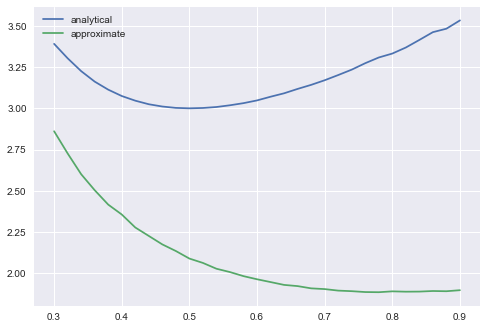

In [11]:
plt.plot(df_analytical["alpha"], df_analytical["energy"], label="analytical")
plt.plot(df_approximate["alpha"], df_approximate["energy"], label="approximate")
plt.legend(loc="best")
plt.show()

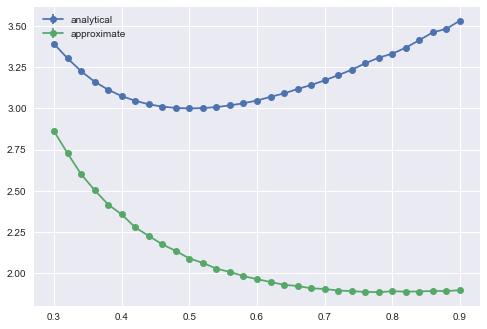

In [12]:
plt.errorbar(
    df_analytical["alpha"], df_analytical["energy"],
    yerr=np.sqrt(df_analytical["variance"])/np.sqrt(num_samples),
    label="analytical", fmt="o-")
plt.errorbar(
    df_approximate["alpha"], df_approximate["energy"],
    yerr=np.sqrt(df_approximate["variance"])/np.sqrt(num_samples),
    label="approximate", fmt="o-")
plt.legend(loc="best")
plt.show()

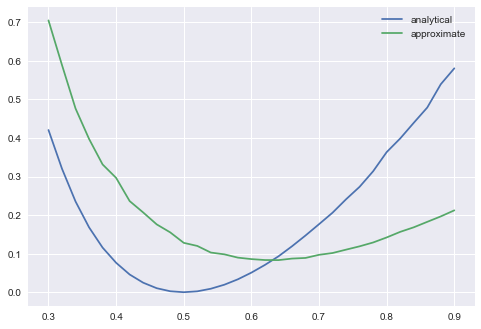

In [13]:
plt.plot(
    df_analytical["alpha"], df_analytical["variance"]/num_particles,
    label="analytical")
plt.plot(
    df_approximate["alpha"], df_approximate["variance"]/num_particles,
    label="approximate")
plt.legend(loc="best")
plt.show()

In [14]:
display(df_analytical)

,alpha,energy,variance,acceptance
0,0.30,3.391361,0.841452,0.603720
1,0.32,3.303716,0.640261,0.591892
2,0.34,3.225730,0.470668,0.579980
3,0.36,3.162146,0.336376,0.569013
4,0.38,3.113332,0.231357,0.559405
5,0.40,3.074723,0.152605,0.549730
6,0.42,3.046419,0.091883,0.539785
7,0.44,3.024740,0.049359,0.531780
8,0.46,3.010946,0.020808,0.522291
9,0.48,3.002653,0.005014,0.513866


In [15]:
display(df_approximate)

,alpha,energy,variance,acceptance
0,0.30,2.860778,1.410133,0.603164
1,0.32,2.726106,1.178098,0.591812
2,0.34,2.599931,0.952984,0.580254
3,0.36,2.502940,0.795106,0.569151
4,0.38,2.415478,0.662810,0.559211
5,0.40,2.355484,0.593128,0.550153
6,0.42,2.276598,0.472796,0.539486
7,0.44,2.225218,0.413780,0.529731
8,0.46,2.173808,0.351875,0.522043
9,0.48,2.133700,0.310335,0.512449


In [16]:
energy_exact = hamiltonian_analytical.compute_exact_energy(
    wavefunction_analytical, alphas=alphas.ravel())

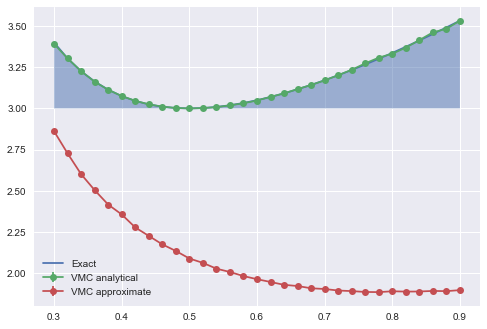

In [17]:
plt.plot(alphas.ravel(), energy_exact, label="Exact")
plt.fill_between(
    alphas.ravel(), min(energy_exact), energy_exact, alpha=0.5)
plt.errorbar(
    df_analytical["alpha"], df_analytical["energy"],
    yerr=np.sqrt(df_analytical["variance"])/np.sqrt(num_samples),
    label="VMC analytical", fmt="o-")
plt.errorbar(
    df_approximate["alpha"], df_approximate["energy"],
    yerr=np.sqrt(df_approximate["variance"])/np.sqrt(num_samples),
    label="VMC approximate", fmt="o-")
plt.legend(loc="best")
plt.show()